# Google Analytics Customer Revenue Prediction

<p><i>Check more about this case study on </i><a href="https://medium.com/@sksaurabh2495/google-analytics-customer-revenue-prediction-bbb6f1be3b7f">[Link]</a></p>
</br>
<a href="https://www.kaggle.com/c/ga-customer-revenue-prediction/">[Kaggle Competition Link]</a>

### Introduction

<p>Onlike marketing is growing very fast as businesses want customers to buy from their store. But their revenue comes from very small parts of the customer. Marketing budgets can be better utilized if they target only potential customers. Google Merchandise Store is a website and has provided the dataset of their website to help us predict customers who are most likely to make a transaction in the future, and the total revenue they will earn from that customer. The goal of this case study is to preprocess the data and use various machine learning algorithms to predict the estimated total revenue the website will earn from a user who visits their website.</p>

### Business Problem

<p>As for every business, the 80-20 rule(The pareto principle), this rule tells us that 80% of revenue is generated by 20% of potential customers. So to better utilize the money for marketing only to those potential customers who are expected to make transactions in the near future, we will be building solutions to predict the revenue that is going to be generated by these customers.</p>
</br>
<p>We are given the users past data and transactions, so by using this data we need to predict the future revenue will be created by those customers. It will help in better use of the marketing budget.</p>

### ML formulation of Business Problem

<p>We will predict how much revenue we will get from the customer(regression problem) who visits the Gstore. Kaggle has provided data in Comma Separated Values(CSV)files, with 1,708,337 rows and 13 attributes. This data can be used for training a Machine learning model and predicting the revenue earned from each and every customer in test.csv file. We first need to understand the data using seaborn and matplotlib. Then we will be doing data preprocessing to make it ready for the Machine Learning model. Then we will apply one evaluation metric to see the performance of our model.</p>

### Business Constraints

<p>We don't require a low latency model because the predicted data will be used by the marketing team whenever ready.</p>

### Dataset column analysis

<ul>
    <li>
        <strong>fullVisitorId</strong> — A unique identifier for each user of the Google Merchandise Store. Our final submission will be dependent on this and will be used for aggregation.
    </li>
    <li>
        <strong>channelGrouping</strong> — The channel via which the user came to the Store.
    </li>
    <li>
        <strong>date</strong> — The date on which the user visited the Store.
    </li>
    <li>
        <strong>device</strong> — The specifications for the device used to access the Store.(json column)
    </li>
    <li>
        <strong>geoNetwork</strong> — This section contains information about the geography of the user.(json column)
    </li>
    <li>
        <strong>socialEngagementType</strong> — Engagement type, either “Socially Engaged” or “Not Socially Engaged”.
    </li>
    <li>
        <strong>totals</strong> — This section contains aggregate values across the session.(json column)
    </li>
    <li>
        <strong>trafficSource</strong> — This section contains information about the Traffic Source from which the session originated.(json column)
    </li>
    <li>
        <strong>visitId</strong> — An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
    </li>
    <li>
        <strong>visitNumber</strong> — The session number for this user. If this is the first session, then this is set to 1.
    </li>
    <li>
        <strong>visitStartTime</strong> — The timestamp (expressed as POSIX time).
    </li>
    <li>
        <strong>hits</strong> — This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
    </li>
    <li>
        <strong>customDimensions</strong> — This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.(json column)
    </li>
    <li>
        <strong>json column</strong>: As we can see, there are few columns that are compressed in json format, we will normalize and convert it to a normal feature.
    </li>
</ul>

### Performance metric

Root Mean Squared Error(RMSE)

$\begin{align}\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}\end{align}$

<p>Here y hat is the natural log of the predicted revenue for a customer and y is the natural log of the actual summed revenue value plus one.</p>

<h5>Why RMSE?</h5>

<p>Penalize large errors - “RMSE increases with the variance of the frequency distribution of error magnitudes.” <a href="https://towardsdatascience.com/which-evaluation-metric-should-you-use-in-machine-learning-regression-problems-20cdaef258e">[Reference]</a></p>
</br>
<p>We want to penalize our model with more the variance from the actual revenue, more will be the error. It will help marketing team not only to target potential customer but also identifying their expenditures.</p>

## Models

### LightGBM

<p>Similar to CatBoost, LightGBM can also handle categorical features by taking the input of feature names. It does not convert to one-hot coding, and is much faster than one-hot coding. LGBM uses a special algorithm to find the split value of categorical features <a href="https://csiss.org/SPACE/workshops/2004/SAC/files/fisher.pdf">[Link]</a>. You should convert your categorical features to int type before you construct a Dataset for LGBM. It does not accept string values even if you passed it through the categorical_feature parameter.</p>

### XGBoost

<p>Unlike CatBoost or LGBM, XGBoost cannot handle categorical features by itself, it only accepts numerical values similar to Random Forest. Therefore one has to perform various encodings like label encoding, mean encoding or one-hot encoding before supplying categorical data to XGBoost.</p>

### Importing necessary libraries

In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from prettytable import PrettyTable
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings("ignore")

### Loading Data

In [2]:
df_train = pd.read_csv('data/train_v2.csv')
df_train.head(5)

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


## Data Preprocessing

<p>Machine Learning algorithms need data in a
clear format, where there is only one attribute per column. Six columns (CustomDimensions, device, geoNetwork, hits, totals, trafficSource) contain the data in JSON format so we will flatten those columns.</p>

### Flattening JSON

In [2]:
# Reference : https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

def load_df(csv_path, nrows = None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, 
                     converters = {column: json.loads for column in JSON_COLUMNS}, 
                     dtype = {'fullVisitorId' : 'str',
                             'date' : 'str',                
                             'visitId' : 'int',
                             'visitNumber' : 'int',
                             'visitStartTime' : 'int',
                             'channelGrouping' : 'str'}
                     )
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis = 1).merge(column_as_df, right_index = True, left_index = True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
df_train = load_df(csv_path = 'data/train_v2.csv')
df_test = load_df(csv_path = 'data/test_v2.csv')

Loaded train_v2.csv. Shape: (1708337, 60)
Loaded test_v2.csv. Shape: (401589, 59)


In [10]:
df_train.head(5)

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Columns with only one unique value

In [8]:
df_distinct = df_train.loc[:, df_train.nunique() <= 1]
print(df_distinct.columns)

Index(['socialEngagementType', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystemVersion', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.bounces', 'totals.newVisits',
       'trafficSource.adwordsClickInfo.criteriaParameters',
       'trafficSource.isTrueDirect',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.campaignCode'],
      dtype='object')


<p>Many of these columns contain only 1
value. So it will not help us to predict the revenue per customer, if all the values are same in a column. We will drop those columns.</p>
<ul>
    <li>
        socialEngagementType
    </li>
    <li>
        device.browserVersion
    </li>
    <li>
        device.browserSize
    </li>
    <li>
        device.operatingSystemVersion
    </li>
    <li>
        device.mobileDeviceBranding
    </li>
    <li>
        device.mobileDeviceModel
    </li>
    <li>
        device.mobileInputSelector
    </li>
    <li>
        device.mobileDeviceInfo
    </li>
    <li>
        device.mobileDeviceMarketingName
    </li>
    <li>
        device.flashVersion
    </li>
    <li>
        device.language
    </li>
    <li>
        device.screenColors
    </li>
    <li>
        device.screenResolution
    </li>
    <li>
        geoNetwork.cityId
    </li>
    <li>
        geoNetwork.latitude
    </li>
    <li>
        geoNetwork.longitude
    </li>
    <li>
        geoNetwork.networkLocation
    </li>
    <li>
        totals.visits
    </li>
    <li>
        totals.bounces
    </li>
    <li>
        totals.newVisits
    </li>
    <li>
        trafficSource.adwordsClickInfo.criteriaParameters
    </li>
    <li>
        trafficSource.isTrueDirect
    </li>
    <li>
        trafficSource.adwordsClickInfo.isVideoAd
    </li>
    <li>
        trafficSource.campaignCode
    </li>
</ul>

In [4]:
cols_to_drop = ['socialEngagementType', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystemVersion', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.bounces', 'totals.newVisits',
       'trafficSource.adwordsClickInfo.criteriaParameters',
       'trafficSource.isTrueDirect',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.campaignCode']
df_train = df_train.drop(cols_to_drop, axis = 1)
df_test = df_test.drop(cols_to_drop, axis = 1, errors='ignore')
df_train.head(5)

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,(not set),google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,1508201613,Chrome,Android,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,1508169851,Chrome,Windows,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,1508190552,Chrome,Windows,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN


### Columns with missing values

In [10]:
percent_missing = df_train.isnull().sum() * 100 / len(df_train)
print(percent_missing)

channelGrouping                                  0.000000
date                                             0.000000
fullVisitorId                                    0.000000
visitId                                          0.000000
visitNumber                                      0.000000
visitStartTime                                   0.000000
device.browser                                   0.000000
device.operatingSystem                           0.000000
device.isMobile                                  0.000000
device.deviceCategory                            0.000000
geoNetwork.continent                             0.000000
geoNetwork.subContinent                          0.000000
geoNetwork.country                               0.000000
geoNetwork.region                                0.000000
geoNetwork.metro                                 0.000000
geoNetwork.city                                  0.000000
geoNetwork.networkDomain                         0.000000
totals.hits   

<p>We are dropping the following columns because they contained more than 95% null values except totals.transactions, totals.transactionRevenue and totals.totalTransactionRevenue</p>
<ul>
    <li>
        trafficSource.adContent
    </li>
    <li>
        trafficSource.adwordsClickInfo.page
    </li>
    <li>
        trafficSource.adwordsClickInfo.slot
    </li>
    <li>
        trafficSource.adwordsClickInfo.gclId
    </li>
    <li>
        trafficSource.adwordsClickInfo.adNetworkType
    </li>
</ul>

In [5]:
cols_to_drop = ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.page',
                         'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.gclId',
                         'trafficSource.adwordsClickInfo.adNetworkType']
df_train = df_train.drop(cols_to_drop, axis = 1)
df_test = df_test.drop(cols_to_drop, axis = 1, errors='ignore')
df_train.head(5)

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,1508201613,Chrome,Android,...,1,38,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,1508169851,Chrome,Windows,...,1,1,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,1508190552,Chrome,Windows,...,1,52,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN


### Unnecessary Columns

<p>customDimensions column values is repeated in geoNetwork column. So we are dropping it.</p>
<p>hits is a record for every activity of the user per hit. It is not useful in prediction. So we are dropping it also.</p>

In [6]:
df_train = df_train.drop(['customDimensions', 'hits'], axis = 1)
df_test = df_test.drop(['customDimensions', 'hits'], axis = 1)
df_train.head(5)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,...,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,NaN
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,...,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,...,1,38,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,...,1,1,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,...,1,52,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN


<p>isMobile is deprecated. We can drop this field as information can be found in deviceCategory. <a href="https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/68232">[Reference]</a></p>

In [7]:
df_train = df_train.drop(['device.isMobile'], axis = 1)
df_test = df_test.drop(['device.isMobile'], axis = 1)

#### Imputing default values

<p>We are setting the default values for the following columns. <a href="https://support.google.com/analytics/answer/3437719">[Reference]</a></p>
<ul>
    <li>
        totals.pageviews
    </li>
    <li>
        totals.sessionQualityDim
    </li>
    <li>
        totals.timeOnSite
    </li>
    <li>
        totals.transactions
    </li>
    <li>
        totals.transactionRevenue
    </li>
    <li>
        totals.totalTransactionRevenue
    </li>
    <li>
        trafficSource.keyword
    </li>
    <li>
        trafficSource.campaign
    </li>
    <li>
        trafficSource.referralPath
    </li>
    <li>
        geoNetwork.city
    </li>
    <li>
        geoNetwork.metro
    </li>
    <li>
        geoNetwork.region
    </li>
    <li>
        geoNetwork.continent
    </li>
    <li>
        device.operatingSystem
    </li>
</ul>

In [8]:
# Train Dataset
df_train['totals.pageviews'].fillna(1, inplace = True)
df_train['totals.sessionQualityDim'].fillna(0, inplace = True)
df_train['totals.timeOnSite'].fillna(0, inplace = True)
df_train['totals.transactions'].fillna(0, inplace = True)
#df_train['totals.transactionRevenue'].fillna(0.0, inplace = True) We will set it later after doing some aggregation on it for EDA
df_train["totals.totalTransactionRevenue"].fillna(0.0, inplace = True)

df_train.loc[df_train['trafficSource.keyword'] == "(not provided)", 'trafficSource.keyword'] = np.nan
df_train['trafficSource.keyword'].fillna("NaN", inplace = True)
df_train.loc[df_train['trafficSource.campaign'] == "(not set)", 'trafficSource.campaign'] = np.nan
df_train['trafficSource.campaign'].fillna("NaN", inplace = True)
df_train['trafficSource.referralPath'].fillna("/google", inplace = True)

df_train.loc[df_train['geoNetwork.city'] == "(not set)", 'geoNetwork.city'] = np.nan
df_train.loc[df_train['geoNetwork.city'] == "not available in demo dataset", 'geoNetwork.city'] = np.nan
df_train['geoNetwork.city'].fillna("NaN", inplace = True)
df_train.loc[df_train['geoNetwork.metro'] == "(not set)", 'geoNetwork.metro'] = np.nan
df_train.loc[df_train['geoNetwork.metro'] == "not available in demo dataset", 'geoNetwork.metro'] = np.nan
df_train['geoNetwork.metro'].fillna("NaN", inplace = True)
df_train.loc[df_train['geoNetwork.region'] == "(not set)", 'geoNetwork.region'] = np.nan
df_train.loc[df_train['geoNetwork.region'] == "not available in demo dataset", 'geoNetwork.region'] = np.nan
df_train['geoNetwork.region'].fillna("NaN", inplace = True)
df_train.loc[df_train['geoNetwork.continent'] == "(not set)", 'geoNetwork.continent'] = np.nan
df_train['geoNetwork.continent'].fillna("NaN", inplace = True)

df_train.loc[df_train['device.operatingSystem'] == "(not set)", 'device.operatingSystem'] = np.nan
df_train['device.operatingSystem'].fillna("NaN", inplace = True)

# Test Dataset
df_test['totals.pageviews'].fillna(1, inplace = True)
df_test['totals.sessionQualityDim'].fillna(0, inplace = True)
df_test['totals.timeOnSite'].fillna(0, inplace = True)
df_test['totals.transactions'].fillna(0, inplace = True)
df_test['totals.transactionRevenue'].fillna(0.0, inplace = True)
df_test["totals.totalTransactionRevenue"].fillna(0.0, inplace = True)

df_test.loc[df_test['trafficSource.keyword'] == "(not provided)", 'trafficSource.keyword'] = np.nan
df_test['trafficSource.keyword'].fillna("NaN", inplace = True)
df_test.loc[df_test['trafficSource.campaign'] == "(not set)", 'trafficSource.campaign'] = np.nan
df_test['trafficSource.campaign'].fillna("NaN", inplace = True)
df_test['trafficSource.referralPath'].fillna("/google", inplace = True)

df_test.loc[df_test['geoNetwork.city'] == "(not set)", 'geoNetwork.city'] = np.nan
df_test.loc[df_test['geoNetwork.city'] == "not available in demo dataset", 'geoNetwork.city'] = np.nan
df_test['geoNetwork.city'].fillna("NaN", inplace = True)
df_test.loc[df_test['geoNetwork.metro'] == "(not set)", 'geoNetwork.metro'] = np.nan
df_test.loc[df_test['geoNetwork.metro'] == "not available in demo dataset", 'geoNetwork.metro'] = np.nan
df_test['geoNetwork.metro'].fillna("NaN", inplace = True)
df_test.loc[df_test['geoNetwork.region'] == "(not set)", 'geoNetwork.region'] = np.nan
df_test.loc[df_test['geoNetwork.region'] == "not available in demo dataset", 'geoNetwork.region'] = np.nan
df_test['geoNetwork.region'].fillna("NaN", inplace = True)
df_test.loc[df_test['geoNetwork.continent'] == "(not set)", 'geoNetwork.continent'] = np.nan
df_test['geoNetwork.continent'].fillna("NaN", inplace = True)

df_test.loc[df_test['device.operatingSystem'] == "(not set)", 'device.operatingSystem'] = np.nan
df_test['device.operatingSystem'].fillna("NaN", inplace = True)

#### Processing date

In [9]:
# Train Dataset
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['day'] = df_train['date'].dt.day
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year
df_train['weekday'] = df_train['date'].dt.weekday

# Test Dataset
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['day'] = df_test['date'].dt.day
df_test['month'] = df_test['date'].dt.month
df_test['year'] = df_test['date'].dt.year
df_test['weekday'] = df_test['date'].dt.weekday

### Undersampling or Oversampling

<p>We found out that undersampling or oversampling techniques did not
help in this problem as "Xavier Bourret Sicotte" applied these techniques in his solution. <a href="https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/67873">[Reference]</a></p>

## Exploratory Data Analysis

### Log on target variable

In [10]:
# Percentage of customers generating transactionRevenue

df_train["totals.transactionRevenue"] = df_train["totals.transactionRevenue"].astype('float')
no_of_users = df_train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().shape[0]
no_of_revenue_generating_users = (df_train["totals.transactionRevenue"] > 0).sum()
print("Percentage of customers generating revenue : ", (no_of_revenue_generating_users / no_of_users) * 100)

Percentage of customers generating revenue :  1.3986235863809084


<p>Very few customers contributing in generating revenue(only 1.3%). Distribution is highly skewed. So we have to use log on the target variable. <a href="https://onlinestatbook.com/2/transformations/log.html" />[Reference]</p>

<h5>Target variable : transactionRevenue</h5>

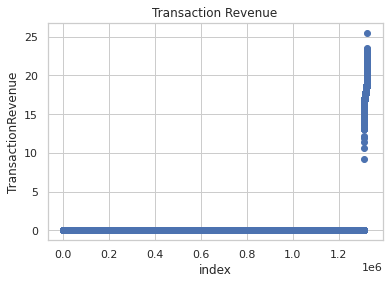

In [12]:
# We have to predict the natural log of sum of all transactions of that user
sns.set(style = 'whitegrid')
transactionRevenue = df_train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.scatter(range(transactionRevenue.shape[0]), np.sort(np.log1p(transactionRevenue["totals.transactionRevenue"].values)))
plt.title("Transaction Revenue")
plt.xlabel('index')
plt.ylabel('TransactionRevenue')
plt.show()

<p>This plot confirms the 80/20 rule. Only small percentage(1.3%) of customers produce most of the revenue.</p>

<h5>Target variable : transactionRevenue distribution</h5>

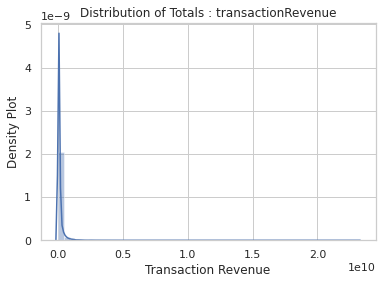

In [13]:
axes = sns.distplot(df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])
axes.set_xlabel('Transaction Revenue')
axes.set_ylabel('Density Plot')
axes.set_title("Distribution of Totals : transactionRevenue")
plt.show()

<i>Log of the Total Transaction Revenue</i>

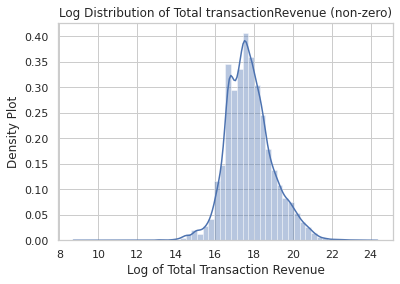

In [14]:
axes = sns.distplot(np.log1p(df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]))
axes.set_xlabel('Log of Total Transaction Revenue')
axes.set_ylabel('Density Plot')
axes.set_title("Log Distribution of Total transactionRevenue (non-zero)")
plt.show()

<p>Pdf of log of transaction revenue is almost normal distributed.</p>

<h5>device.browser</h5>

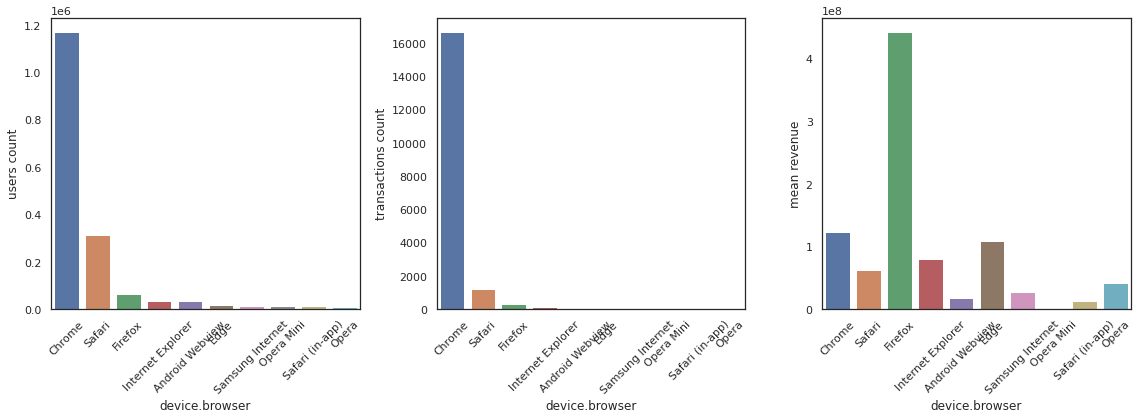

In [24]:
agg_ttr = df_train.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean']) # size will count all totals.transactionRevenue cointaining null = users count ; count will count only not null totals.transactionRevenue = transactions that happened
agg_ttr.columns = ['users count', 'transactions count', 'mean revenue']
agg_ttr.reset_index(inplace = True)
agg_ttr = agg_ttr.sort_values(by = 'users count', ascending = False)

fig, axes = plt.subplots(1, 3, figsize = (16, 6))
axes[0].tick_params(axis = 'x', rotation = 45)
axes[1].tick_params(axis = 'x', rotation = 45)
axes[2].tick_params(axis = 'x', rotation = 45)
sns.barplot(x = 'device.browser', y = 'users count', data = agg_ttr.head(10), ax = axes[0])
sns.barplot(x = 'device.browser', y = 'transactions count', data = agg_ttr.head(10), ax = axes[1])
sns.barplot(x = 'device.browser', y = 'mean revenue', data = agg_ttr.head(10), ax = axes[2])
sns.set(font_scale = 1)
sns.set(style = 'white')
plt.tight_layout()

<p>Chrome is the most widely used browser. Safari also shares some part of it. Rest of the browser doesn't contribute much.</p>

<h5>device.deviceCategory</h5>

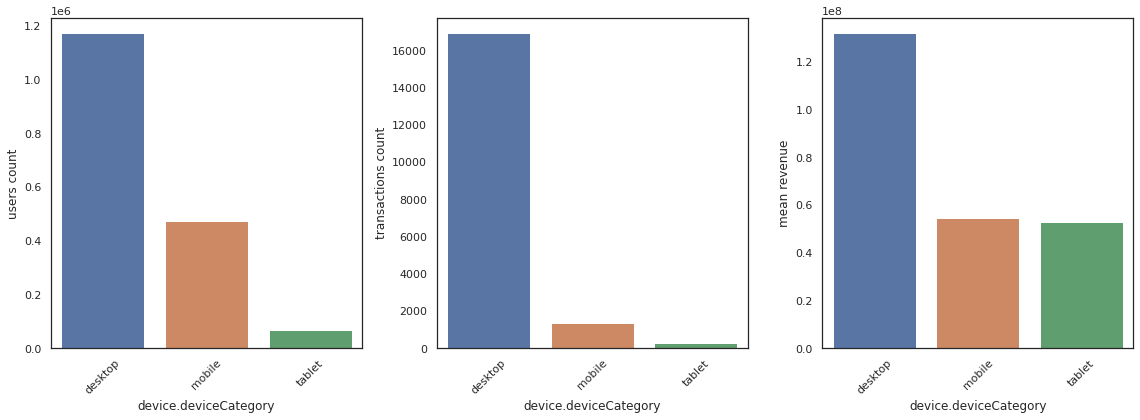

In [25]:
agg_ttr = df_train.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
agg_ttr.columns = ['users count', 'transactions count', 'mean revenue']
agg_ttr.reset_index(inplace = True)
agg_ttr = agg_ttr.sort_values(by = 'users count', ascending = False)

fig, axes = plt.subplots(1, 3, figsize = (16, 6))
axes[0].tick_params(axis = 'x', rotation = 45)
axes[1].tick_params(axis = 'x', rotation = 45)
axes[2].tick_params(axis = 'x', rotation = 45)
sns.barplot(x = 'device.deviceCategory', y = 'users count', data = agg_ttr.head(10), ax = axes[0])
sns.barplot(x = 'device.deviceCategory', y = 'transactions count', data = agg_ttr.head(10), ax = axes[1])
sns.barplot(x = 'device.deviceCategory', y = 'mean revenue', data = agg_ttr.head(10), ax = axes[2])
sns.set(font_scale = 1)
sns.set(style = 'white')
plt.tight_layout()

<p>This is the bar plot for device used by users. Desktop is the most widely used device.</p>

<h5>device.operatingSystem</h5>

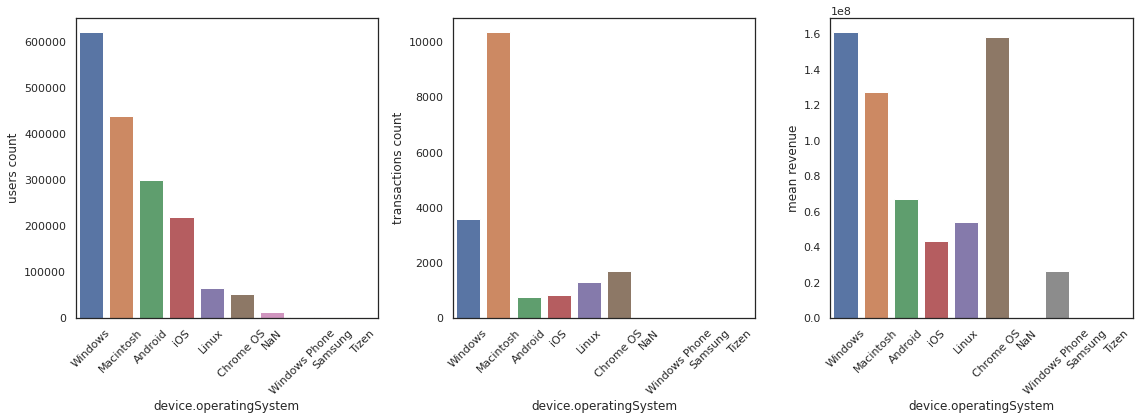

In [26]:
agg_ttr = df_train.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
agg_ttr.columns = ['users count', 'transactions count', 'mean revenue']
agg_ttr.reset_index(inplace = True)
agg_ttr = agg_ttr.sort_values(by = 'users count', ascending = False)

fig, axes = plt.subplots(1, 3, figsize = (16, 6))
axes[0].tick_params(axis = 'x', rotation = 45)
axes[1].tick_params(axis = 'x', rotation = 45)
axes[2].tick_params(axis = 'x', rotation = 45)
sns.barplot(x = 'device.operatingSystem', y = 'users count', data = agg_ttr.head(10), ax = axes[0])
sns.barplot(x = 'device.operatingSystem', y = 'transactions count', data = agg_ttr.head(10), ax = axes[1])
sns.barplot(x = 'device.operatingSystem', y = 'mean revenue', data = agg_ttr.head(10), ax = axes[2])
sns.set(font_scale = 1)
sns.set(style = 'white')
plt.tight_layout()

<p>Windows contributed the most for user visits. But users using Macintosh did more transactions than windows.</p>

<h5>visitNumber : User visits</h5>

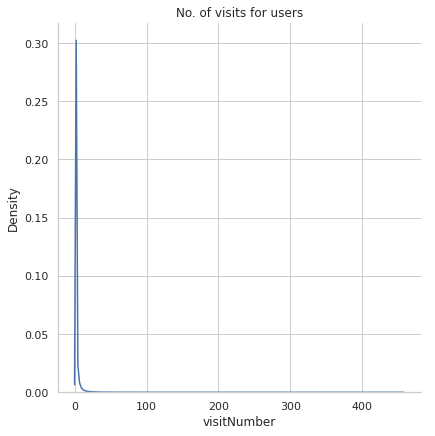

In [28]:
sns.FacetGrid(df_train, height = 6).map(sns.kdeplot, 'visitNumber').add_legend()
plt.title("No. of visits for users")
sns.set(style = 'whitegrid')
plt.show()

<p>You can see the skewed distribution here as very less no of users visits the website again.</p>

In [93]:
# Percentile values for no. of times user visited Gstore

for i in range(0, 100, 10):
    user_visits = df_train["visitNumber"].values
    user_visits = np.sort(user_visits, axis = None)
    print("{}th Percentile : ".format(i), user_visits[int(len(user_visits) * (float(i) / 100))])
print ("100th Percentile : ", user_visits[-1])

0th Percentile :  1
10th Percentile :  1
20th Percentile :  1
30th Percentile :  1
40th Percentile :  1
50th Percentile :  1
60th Percentile :  1
70th Percentile :  1
80th Percentile :  2
90th Percentile :  3
100th Percentile :  457


<p>Lets zoom 90th to 100th percentile</p>

In [94]:
for i in range(90, 100):
    user_visits = df_train["visitNumber"].values
    user_visits = np.sort(user_visits, axis = None)
    print("{}th Percentile : ".format(i), user_visits[int(len(user_visits) * (float(i) / 100))])
print ("100th Percentile : ", user_visits[-1])

90th Percentile :  3
91th Percentile :  3
92th Percentile :  4
93th Percentile :  4
94th Percentile :  5
95th Percentile :  6
96th Percentile :  7
97th Percentile :  8
98th Percentile :  12
99th Percentile :  22
100th Percentile :  457


<p>Lets zoom 99th to 100th percentile</p>

In [98]:
for i in np.arange(99, 100, 0.1):
    user_visits = df_train["visitNumber"].values
    user_visits = np.sort(user_visits, axis = None)
    print("{0:.1f}th Percentile : ".format(i), user_visits[int(len(user_visits) * (float(i) / 100))])
print ("100th Percentile : ", user_visits[-1])

99.0th Percentile :  22
99.1th Percentile :  24
99.2th Percentile :  27
99.3th Percentile :  30
99.4th Percentile :  35
99.5th Percentile :  42
99.6th Percentile :  53
99.7th Percentile :  69
99.8th Percentile :  98
99.9th Percentile :  145
100th Percentile :  457


<p>There are very few people who visits the Gstore frequently.</p>

<h5>geoNetwork.continent</h5>

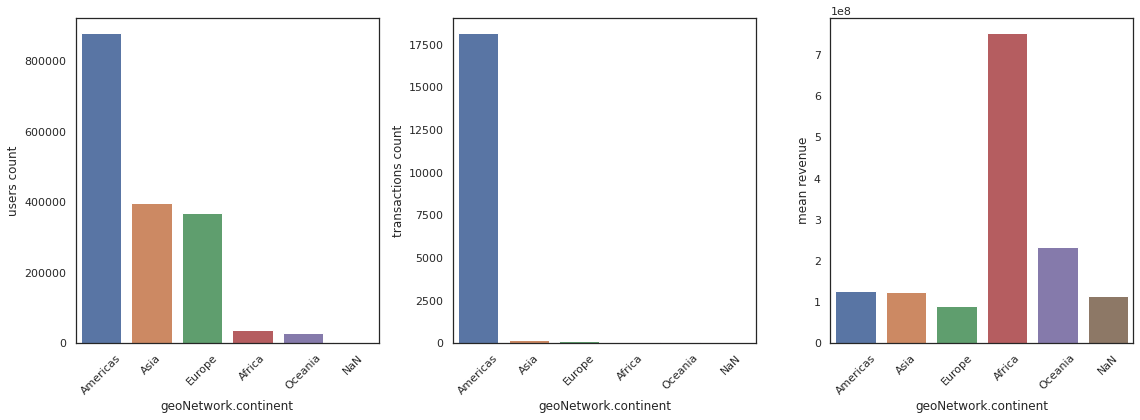

In [30]:
agg_ttr = df_train.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
agg_ttr.columns = ['users count', 'transactions count', 'mean revenue']
agg_ttr.reset_index(inplace = True)
agg_ttr = agg_ttr.sort_values(by = 'users count', ascending = False)

fig, axes = plt.subplots(1, 3, figsize = (16, 6))
axes[0].tick_params(axis = 'x', rotation = 45)
axes[1].tick_params(axis = 'x', rotation = 45)
axes[2].tick_params(axis = 'x', rotation = 45)
sns.barplot(x = 'geoNetwork.continent', y = 'users count', data = agg_ttr.head(10), ax = axes[0])
sns.barplot(x = 'geoNetwork.continent', y = 'transactions count', data = agg_ttr.head(10), ax = axes[1])
sns.barplot(x = 'geoNetwork.continent', y = 'mean revenue', data = agg_ttr.head(10), ax = axes[2])
sns.set(font_scale = 1)
sns.set(style = 'white')
plt.tight_layout()

<p>Most of the users are from america. Ratio of america to asia and europe for vists is better than for transactions. That means conversion rate(from visit to make a transaction) is Better for America.</p>

<h5>geoNetwork.subContinent</h5>

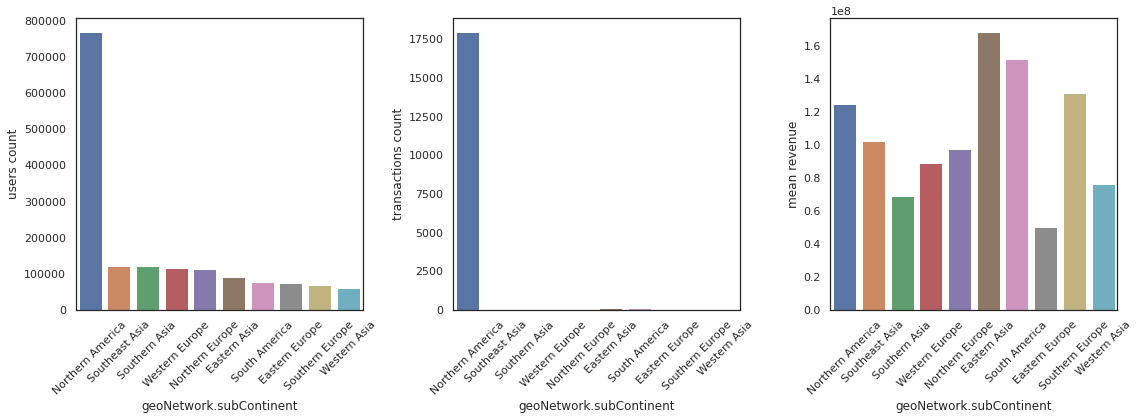

In [31]:
agg_ttr = df_train.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
agg_ttr.columns = ['users count', 'transactions count', 'mean revenue']
agg_ttr.reset_index(inplace = True)
agg_ttr = agg_ttr.sort_values(by = 'users count', ascending = False)

fig, axes = plt.subplots(1, 3, figsize = (16, 6))
axes[0].tick_params(axis = 'x', rotation = 45)
axes[1].tick_params(axis = 'x', rotation = 45)
axes[2].tick_params(axis = 'x', rotation = 45)
sns.barplot(x = 'geoNetwork.subContinent', y = 'users count', data = agg_ttr.head(10), ax = axes[0])
sns.barplot(x = 'geoNetwork.subContinent', y = 'transactions count', data = agg_ttr.head(10), ax = axes[1])
sns.barplot(x = 'geoNetwork.subContinent', y = 'mean revenue', data = agg_ttr.head(10), ax = axes[2])
sns.set(font_scale = 1)
sns.set(style = 'white')
plt.tight_layout()

<p>Northern america contributing the most. In the other subcontinent, distribution is almost equal. Conversion rate(from visit to make a transaction) is Better for Northern America than any other subcontinent.</p>

<h5>geoNetwork.country</h5>

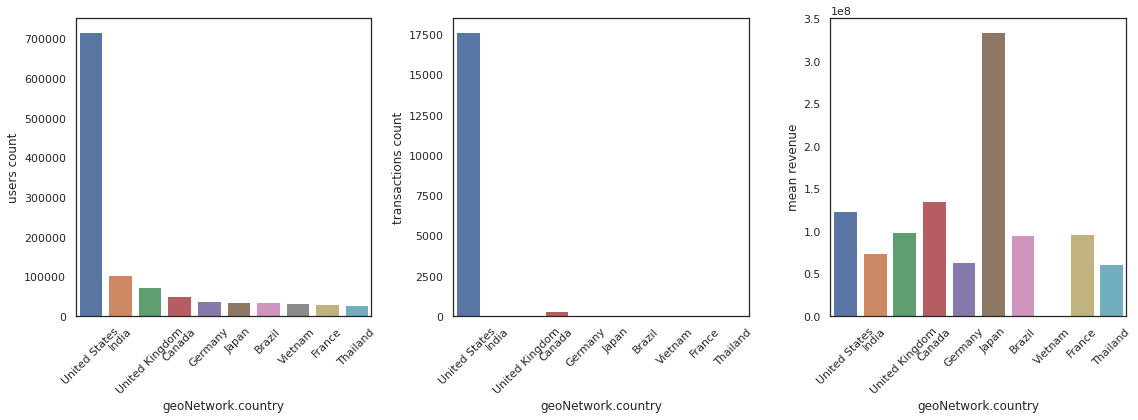

In [32]:
agg_ttr = df_train.groupby('geoNetwork.country')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
agg_ttr.columns = ['users count', 'transactions count', 'mean revenue']
agg_ttr.reset_index(inplace = True)
agg_ttr = agg_ttr.sort_values(by = 'users count', ascending = False)

fig, axes = plt.subplots(1, 3, figsize = (16, 6))
axes[0].tick_params(axis = 'x', rotation = 45)
axes[1].tick_params(axis = 'x', rotation = 45)
axes[2].tick_params(axis = 'x', rotation = 45)
sns.barplot(x = 'geoNetwork.country', y = 'users count', data = agg_ttr.head(10), ax = axes[0])
sns.barplot(x = 'geoNetwork.country', y = 'transactions count', data = agg_ttr.head(10), ax = axes[1])
sns.barplot(x = 'geoNetwork.country', y = 'mean revenue', data = agg_ttr.head(10), ax = axes[2])
sns.set(font_scale = 1)
sns.set(style = 'white')
plt.tight_layout()

<p>United states contributing the most. Conversion rate(from visit to make a transaction) is Better for United states than any other country.</p>

<h5>geoNetwork.city</h5>

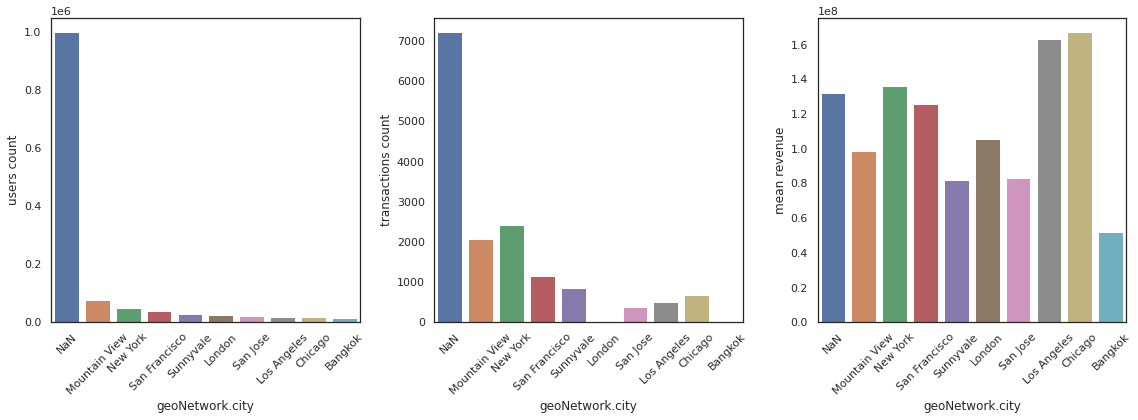

In [33]:
agg_ttr = df_train.groupby('geoNetwork.city')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
agg_ttr.columns = ['users count', 'transactions count', 'mean revenue']
agg_ttr.reset_index(inplace = True)
agg_ttr = agg_ttr.sort_values(by = 'users count', ascending = False)

fig, axes = plt.subplots(1, 3, figsize = (16, 6))
axes[0].tick_params(axis = 'x', rotation = 45)
axes[1].tick_params(axis = 'x', rotation = 45)
axes[2].tick_params(axis = 'x', rotation = 45)
sns.barplot(x = 'geoNetwork.city', y = 'users count', data = agg_ttr.head(10), ax = axes[0])
sns.barplot(x = 'geoNetwork.city', y = 'transactions count', data = agg_ttr.head(10), ax = axes[1])
sns.barplot(x = 'geoNetwork.city', y = 'mean revenue', data = agg_ttr.head(10), ax = axes[2])
sns.set(font_scale = 1)
sns.set(style = 'white')
plt.tight_layout()

<p>For the cities, most of the values are not available. Mountain view tops in visits but for doing a transaction New York tops.</p>

<h5>channelGrouping</h5>

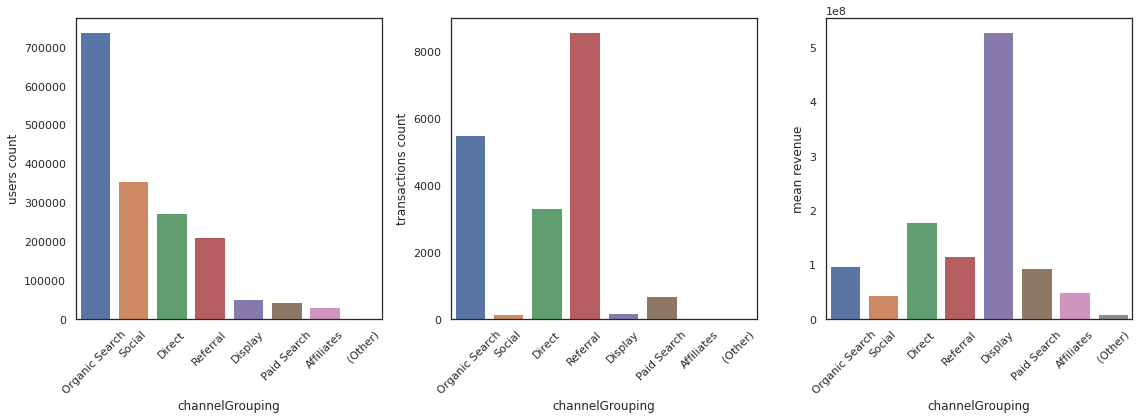

In [34]:
agg_ttr = df_train.groupby('channelGrouping')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
agg_ttr.columns = ['users count', 'transactions count', 'mean revenue']
agg_ttr.reset_index(inplace = True)
agg_ttr = agg_ttr.sort_values(by = 'users count', ascending = False)

fig, axes = plt.subplots(1, 3, figsize = (16, 6))
axes[0].tick_params(axis = 'x', rotation = 45)
axes[1].tick_params(axis = 'x', rotation = 45)
axes[2].tick_params(axis = 'x', rotation = 45)
sns.barplot(x = 'channelGrouping', y = 'users count', data = agg_ttr.head(10), ax = axes[0])
sns.barplot(x = 'channelGrouping', y = 'transactions count', data = agg_ttr.head(10), ax = axes[1])
sns.barplot(x = 'channelGrouping', y = 'mean revenue', data = agg_ttr.head(10), ax = axes[2])
sns.set(font_scale = 1)
sns.set(style = 'white')
plt.tight_layout()

<p>This field can be very helpful for the predictions. There is good vaiance in it. Users from Referral did more the transactions yet visits for users from Organic Search is more.</p>

<h5>trafficSource.source</h5>

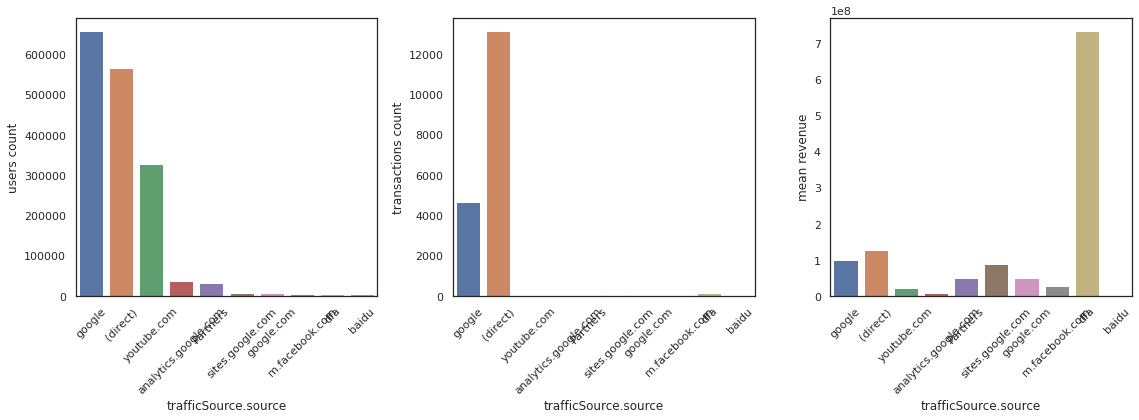

In [35]:
agg_ttr = df_train.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
agg_ttr.columns = ['users count', 'transactions count', 'mean revenue']
agg_ttr.reset_index(inplace = True)
agg_ttr = agg_ttr.sort_values(by = 'users count', ascending = False)

fig, axes = plt.subplots(1, 3, figsize = (16, 6))
axes[0].tick_params(axis = 'x', rotation = 45)
axes[1].tick_params(axis = 'x', rotation = 45)
axes[2].tick_params(axis = 'x', rotation = 45)
sns.barplot(x = 'trafficSource.source', y = 'users count', data = agg_ttr.head(10), ax = axes[0])
sns.barplot(x = 'trafficSource.source', y = 'transactions count', data = agg_ttr.head(10), ax = axes[1])
sns.barplot(x = 'trafficSource.source', y = 'mean revenue', data = agg_ttr.head(10), ax = axes[2])
sns.set(font_scale = 1)
sns.set(style = 'white')
plt.tight_layout()

<p>Most of the users came from google but they did transactions less than the people who came direct.</p>

<h5>channelGrouping with browser</h5>

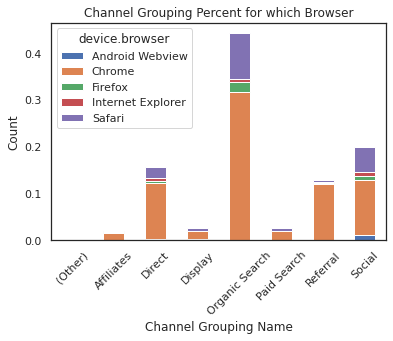

In [37]:
crosstab_cg_b = pd.crosstab(index = df_train['channelGrouping'], normalize = True,
                           # isin to select the top 5 browsers
                           columns = df_train[df_train['device.browser'].isin(df_train['device.browser'].value_counts()[:5].index.values)]['device.browser'])

crosstab_cg_b.plot(kind = "bar", stacked = True)
plt.title("Channel Grouping Percent for which Browser")
plt.xlabel("Channel Grouping Name",)
plt.ylabel("Count")
plt.xticks(rotation = 45)
sns.set(style = 'white')
plt.show()

<p>Organic search in chrome is the most widely used. Marketing team can target these users.</p>

<h5>date</h5>

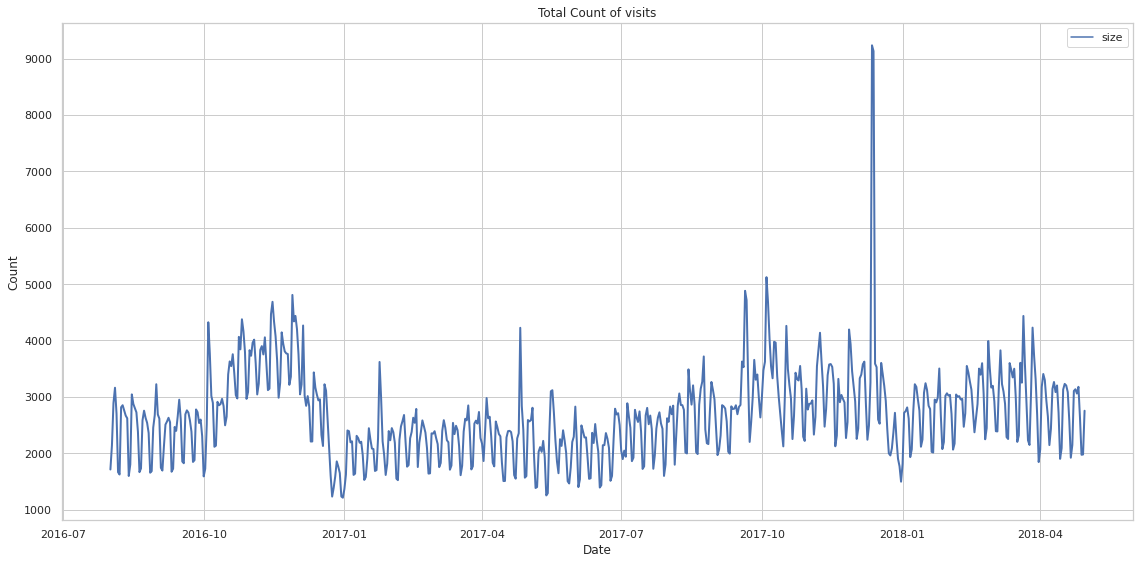

In [39]:
# Total Count of visits

agg_ttr = df_train.groupby('date')['totals.transactionRevenue'].agg(['size'])
fig, axes = plt.subplots(figsize = (16, 8))
sns.lineplot(data = agg_ttr, linewidth = 2)
plt.title('Total Count of visits')
plt.xlabel('Date')
plt.ylabel('Count')
sns.set(style = 'whitegrid')
plt.tight_layout()

<p>Users visited most during the end of 2017 because of christmas and new year.</p>

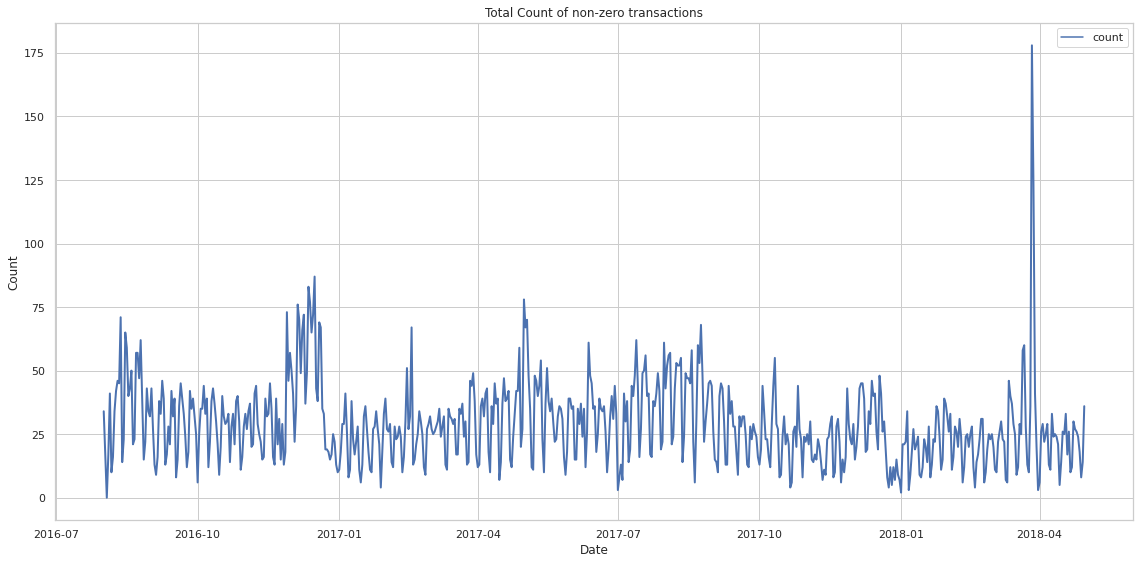

In [40]:
# Total Count of non-zero transactions

agg_ttr = df_train.groupby("date")['totals.transactionRevenue'].agg(['count'])
fig, axes = plt.subplots(figsize = (16, 8))
sns.lineplot(data = agg_ttr, linewidth = 2)
plt.title('Total Count of non-zero transactions')
plt.xlabel('Date')
plt.ylabel('Count')
sns.set(style = 'whitegrid')
plt.tight_layout()

<p>Users visited most during the end of 2017 because of christmas and new year(from previous plot) but they didn't make the transaction.</p>

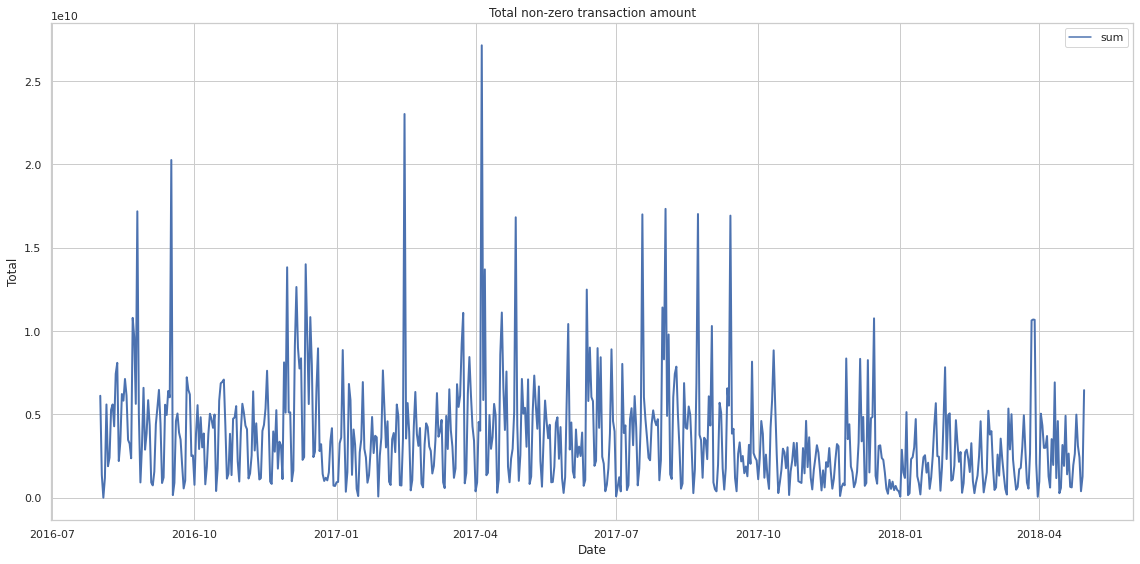

In [41]:
# Total non-zero transaction amount

agg_ttr = df_train.groupby("date")['totals.transactionRevenue'].agg(['sum'])
fig, axes = plt.subplots(figsize = (16, 8))
sns.lineplot(data = agg_ttr, linewidth = 2)
plt.title('Total non-zero transaction amount')
plt.xlabel('Date')
plt.ylabel('Total')
sns.set(style = 'whitegrid')
plt.tight_layout()

<p>More of the revenue generated during april.</p>

## Feature Engineering

In [11]:
df_train['totals.transactionRevenue'].fillna(0.0, inplace = True) # We are setting it after EDA because we did some aggregation on it

In [12]:
# Converting the string variables to float/int
# Train Dataset
df_train["totals.hits"] = df_train["totals.hits"].astype('int')
df_train["totals.pageviews"] = df_train["totals.pageviews"].astype('int')
df_train["totals.sessionQualityDim"] = df_train["totals.sessionQualityDim"].astype('int')
df_train["totals.timeOnSite"] = df_train["totals.timeOnSite"].astype('int')
df_train["totals.transactions"] = df_train["totals.transactions"].astype('int')
df_train["totals.totalTransactionRevenue"] = df_train["totals.totalTransactionRevenue"].astype('float')

# Test Dataset
df_test["totals.hits"] = df_test["totals.hits"].astype('int')
df_test["totals.pageviews"] = df_test["totals.pageviews"].astype('int')
df_test["totals.sessionQualityDim"] = df_test["totals.sessionQualityDim"].astype('int')
df_test["totals.timeOnSite"] = df_test["totals.timeOnSite"].astype('int')
df_test["totals.transactions"] = df_test["totals.transactions"].astype('int')
df_test["totals.transactionRevenue"] = df_test["totals.transactionRevenue"].astype('float')
df_test["totals.totalTransactionRevenue"] = df_test["totals.totalTransactionRevenue"].astype('float')

<h5>Adding some features</h5>

In [13]:
# Train Dataset
# Number of unique users per day, month, weekday
df_train['day_unique_user_count'] = df_train.groupby('day')['fullVisitorId'].transform('nunique')
df_train['month_unique_user_count'] = df_train.groupby('month')['fullVisitorId'].transform('nunique')
df_train['weekday_unique_user_count'] = df_train.groupby('weekday')['fullVisitorId'].transform('nunique')
# Total number of visits, count, mean, max, min of visits per fullVisitorId
df_train['visitNumber_sum'] = df_train.groupby('fullVisitorId')['visitNumber'].transform('sum')
df_train['visitNumber_count'] = df_train.groupby('fullVisitorId')['visitNumber'].transform('count')
df_train['visitNumber_mean'] = df_train.groupby('fullVisitorId')['visitNumber'].transform('mean')
df_train['visitNumber_max'] = df_train.groupby('fullVisitorId')['visitNumber'].transform('max')
df_train['visitNumber_min'] = df_train.groupby('fullVisitorId')['visitNumber'].transform('min')
# Sum, count, mean, max, min, of hits per fullVisitorId
df_train['hits_sum'] = df_train.groupby('fullVisitorId')['totals.hits'].transform('sum')
df_train['hits_count']  = df_train.groupby('fullVisitorId')['totals.hits'].transform('count')
df_train['hits_mean'] = df_train.groupby('fullVisitorId')['totals.hits'].transform('mean')
df_train['hits_max'] = df_train.groupby('fullVisitorId')['totals.hits'].transform('max')
df_train['hits_min'] = df_train.groupby('fullVisitorId')['totals.hits'].transform('min')
# Sum, count, mean, max, min of pageviews per fullVisitorId
df_train['pageviews_sum'] = df_train.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
df_train['pageviews_count'] = df_train.groupby('fullVisitorId')['totals.pageviews'].transform('count')
df_train['pageviews_mean'] = df_train.groupby('fullVisitorId')['totals.pageviews'].transform('mean')
df_train['pageviews_max'] = df_train.groupby('fullVisitorId')['totals.pageviews'].transform('max')
df_train['pageviews_min'] = df_train.groupby('fullVisitorId')['totals.pageviews'].transform('min')
# Sum, count, mean, max, min of total time spent per fullVisitorId
df_train['timeOnSite_sum'] = df_train.groupby('fullVisitorId')['totals.timeOnSite'].transform('sum')
df_train['timeOnSite_count'] = df_train.groupby('fullVisitorId')['totals.timeOnSite'].transform('count')
df_train['timeOnSite_mean'] = df_train.groupby('fullVisitorId')['totals.timeOnSite'].transform('mean')
df_train['timeOnSite_max'] = df_train.groupby('fullVisitorId')['totals.timeOnSite'].transform('max')
df_train['timeOnSite_min'] = df_train.groupby('fullVisitorId')['totals.timeOnSite'].transform('min')
# Count of visitStartTime per fullVisitorId
df_train['visitStartTime_count'] = df_train.groupby('fullVisitorId')['visitStartTime'].transform('count')
# Sum of transactions per fullVisitorId
df_train['transactions_sum'] = df_train.groupby('fullVisitorId')['totals.transactions'].transform('sum')
# Sum of transactionRevenue per fullVisitorId
df_train['transactionRevenue_sum'] = df_train.groupby('fullVisitorId')['totals.transactionRevenue'].transform('sum')

# Test Dataset
# Number of unique users per day, month, weekday
df_test['day_unique_user_count'] = df_test.groupby('day')['fullVisitorId'].transform('nunique')
df_test['month_unique_user_count'] = df_test.groupby('month')['fullVisitorId'].transform('nunique')
df_test['weekday_unique_user_count'] = df_test.groupby('weekday')['fullVisitorId'].transform('nunique')
# Total number of visits, count, mean, max, min of visits per fullVisitorId
df_test['visitNumber_sum'] = df_test.groupby('fullVisitorId')['visitNumber'].transform('sum')
df_test['visitNumber_count'] = df_test.groupby('fullVisitorId')['visitNumber'].transform('count')
df_test['visitNumber_mean'] = df_test.groupby('fullVisitorId')['visitNumber'].transform('mean')
df_test['visitNumber_max'] = df_test.groupby('fullVisitorId')['visitNumber'].transform('max')
df_test['visitNumber_min'] = df_test.groupby('fullVisitorId')['visitNumber'].transform('min')
# Sum, count, mean, max, min, of hits per fullVisitorId
df_test['hits_sum'] = df_test.groupby('fullVisitorId')['totals.hits'].transform('sum')
df_test['hits_count']  = df_test.groupby('fullVisitorId')['totals.hits'].transform('count')
df_test['hits_mean'] = df_test.groupby('fullVisitorId')['totals.hits'].transform('mean')
df_test['hits_max'] = df_test.groupby('fullVisitorId')['totals.hits'].transform('max')
df_test['hits_min'] = df_test.groupby('fullVisitorId')['totals.hits'].transform('min')
# Sum, count, mean, max, min of pageviews per fullVisitorId
df_test['pageviews_sum'] = df_test.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
df_test['pageviews_count'] = df_test.groupby('fullVisitorId')['totals.pageviews'].transform('count')
df_test['pageviews_mean'] = df_test.groupby('fullVisitorId')['totals.pageviews'].transform('mean')
df_test['pageviews_max'] = df_test.groupby('fullVisitorId')['totals.pageviews'].transform('max')
df_test['pageviews_min'] = df_test.groupby('fullVisitorId')['totals.pageviews'].transform('min')
# Sum, count, mean, max, min of total time spent per fullVisitorId
df_test['timeOnSite_sum'] = df_test.groupby('fullVisitorId')['totals.timeOnSite'].transform('sum')
df_test['timeOnSite_count'] = df_test.groupby('fullVisitorId')['totals.timeOnSite'].transform('count')
df_test['timeOnSite_mean'] = df_test.groupby('fullVisitorId')['totals.timeOnSite'].transform('mean')
df_test['timeOnSite_max'] = df_test.groupby('fullVisitorId')['totals.timeOnSite'].transform('max')
df_test['timeOnSite_min'] = df_test.groupby('fullVisitorId')['totals.timeOnSite'].transform('min')
# Count of visitStartTime per fullVisitorId
df_test['visitStartTime_count'] = df_test.groupby('fullVisitorId')['visitStartTime'].transform('count')
# Sum of transactions per fullVisitorId
df_test['transactions_sum'] = df_test.groupby('fullVisitorId')['totals.transactions'].transform('sum')
# Sum of transactionRevenue per fullVisitorId
df_test['transactionRevenue_sum'] = df_test.groupby('fullVisitorId')['totals.transactionRevenue'].transform('sum')

<h5>Target Variable : totals.transactionRevenue</h5>

<p>Target variable for the regression problem is supposed to be log(sum of all transactions per user + 1).</p>

In [21]:
#target_train = df_train.groupby('fullVisitorId')[['totals.transactionRevenue']].sum().apply(np.log1p, axis = 1).reset_index()
target_train = df_train['totals.transactionRevenue'].apply(np.log1p)
#target_train.rename(columns = {'totals.transactionRevenue' : 'target'}, inplace = True)

In [23]:
target_train

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1708332    0.0
1708333    0.0
1708334    0.0
1708335    0.0
1708336    0.0
Name: totals.transactionRevenue, Length: 1708337, dtype: float64

### Column for classification

<p>Before doing regression, we are doing classification on our problem to check whether a user will do a transaction or not. This feature later can be used for regression.</p>

In [24]:
df_train_classifier = df_train['totals.transactionRevenue'].apply(lambda x : 1 if x > 0 else 0)

In [25]:
# Storing fullVisitorId for prediction file
fullVisitorIds = df_test['fullVisitorId'].values

In [26]:
# Dropping unwanted columns
df_train = df_train.drop(['fullVisitorId', 'visitId', 'visitStartTime', 'date', 'totals.transactionRevenue'], axis = 1)
df_test = df_test.drop(['fullVisitorId', 'visitId', 'visitStartTime', 'date', 'totals.transactionRevenue'], axis = 1)

### Label Encode Categorical Features

In [27]:
category_cols = ['channelGrouping', 'device.browser', 'device.operatingSystem',
                'device.deviceCategory', 'geoNetwork.continent', 'geoNetwork.subContinent',
                'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro',
                'geoNetwork.city', 'geoNetwork.networkDomain', 'trafficSource.campaign',
                'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
                'trafficSource.referralPath']
           
for col in category_cols:
    le = preprocessing.LabelEncoder()
    le.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
    df_train[col] = le.transform(list(df_train[col].values.astype('str')))
    df_test[col] = le.transform(list(df_test[col].values.astype('str')))

In [28]:
# Final Dataframe
df_train.head(5)

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,...,pageviews_max,pageviews_min,timeOnSite_sum,timeOnSite_count,timeOnSite_mean,timeOnSite_max,timeOnSite_min,visitStartTime_count,transactions_sum,transactionRevenue_sum
0,4,1,64,22,0,3,22,75,288,75,...,1,1,0,1,0.000000,0,0,1,0,0.0
1,6,6,55,2,0,1,12,219,73,104,...,23,2,2589,7,369.857143,1108,15,7,2,26380000.0
2,2,1,55,0,1,1,12,219,288,75,...,2,2,38,1,38.000000,38,38,1,0,0.0
3,4,1,55,22,0,2,21,211,288,75,...,2,2,1,1,1.000000,1,1,1,0,0.0
4,4,1,55,22,0,1,3,132,288,75,...,2,2,52,1,52.000000,52,52,1,0,0.0


## Machine Learning Model

### Hyperparameter tuning for the LightGBM Classification Model

In [21]:
params = {
    'learning_rate' : [0.005, 0.01, 0.015],
    'n_estimators' : [40, 100, 200], 
    'metric' : ['binary_logloss'],
    'objective' : ['binary'],
    'min_child_samples' : [1, 20],
    'subsample' : [0.7, 0.9, 1],
    'colsample_bytree' : [0.6, 0.8, 1],
    'num_leaves' : [6, 8, 12, 15, 16, 20],
    'reg_alpha' : [0, 1],
    'reg_lambda' : [0, 1]
    }

In [22]:
# Initializing LightGBM Classification model
lgbm = lgb.LGBMClassifier()

# GridSearchCV for Hypertunning
clf = GridSearchCV(lgbm, params, cv = 3, n_jobs = -1)

# Running GridSearchCV on train dataset to find tuned parameters
clf.fit(df_train, df_train_classifier.values)

GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1],
                         'learning_rate': [0.005, 0.01, 0.015],
                         'metric': ['binary_logloss'],
                         'min_child_samples': [1, 20],
                         'n_estimators': [40, 100, 200],
                         'num_leaves': [6, 8, 12, 15, 16, 20],
                         'objective': ['binary'], 'reg_alpha': [0, 1],
                         'reg_lambda': [0, 1], 'subsample': [0.7, 0.9, 1]})

In [23]:
# Best parameters
print(clf.best_score_)
print(clf.best_params_)

1.0
{'colsample_bytree': 0.6, 'learning_rate': 0.005, 'metric': 'binary_logloss', 'min_child_samples': 1, 'n_estimators': 200, 'num_leaves': 6, 'objective': 'binary', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.7}


### Train LightGBM Classification model with tuned parameters

In [24]:
params = {
    'learning_rate' : 0.005,
    'n_estimators' : 200, 
    'metric' : ['binary_logloss'],
    'objective' : ['binary'],
    'min_child_samples' : 1,
    'subsample' : 0.7,
    'colsample_bytree' : 0.6,
    'num_leaves' : 6,
    'reg_alpha' : 0,
    'reg_lambda' : 0
    }

In [25]:
# Defining dataset for LGBM
df_train_lgbm = lgb.Dataset(df_train, label = df_train_classifier.values)

# Training our model on train dataset
lgbm_model = lgb.train(params, df_train_lgbm)

# Saving model
lgbm_model.save_model('lgbm_model_classifier.txt' )

[LightGBM] [Info] Number of positive: 18514, number of negative: 1689823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.324197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6899
[LightGBM] [Info] Number of data points in the train set: 1708337, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010837 -> initscore=-4.513852
[LightGBM] [Info] Start training from score -4.513852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [29]:
# Loading saved model
lgbm_model = lgb.Booster(model_file='lgbm_model_classifier.txt')

In [33]:
# Predicting on test dataset
y_pred = lgbm_model.predict(df_test)
# We got the probability values of belonging to class 1. Now we will transform our predictions into binary form of 0 and 1.
y_pred = np.where(y_pred > 0.5, 1, 0)

In [34]:
# Predictions for test dataset
y_pred

array([0, 0, 0, ..., 0, 0, 0])

<p>Now, we will add our predictions from classication model to our dataframe as new feature.</p>

In [35]:
df_train["revenue_generated"] = df_train_classifier.values
df_test["revenue_generated"] = y_pred

In [36]:
df_train.head(5)

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,...,pageviews_min,timeOnSite_sum,timeOnSite_count,timeOnSite_mean,timeOnSite_max,timeOnSite_min,visitStartTime_count,transactions_sum,transactionRevenue_sum,revenue_generated
0,4,1,64,22,0,3,22,75,288,75,...,1,0,1,0.000000,0,0,1,0,0.0,0
1,6,6,55,2,0,1,12,219,73,104,...,2,2589,7,369.857143,1108,15,7,2,26380000.0,0
2,2,1,55,0,1,1,12,219,288,75,...,2,38,1,38.000000,38,38,1,0,0.0,0
3,4,1,55,22,0,2,21,211,288,75,...,2,1,1,1.000000,1,1,1,0,0.0,0
4,4,1,55,22,0,1,3,132,288,75,...,2,52,1,52.000000,52,52,1,0,0.0,0


In [37]:
df_test.head(5)

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,...,pageviews_min,timeOnSite_sum,timeOnSite_count,timeOnSite_mean,timeOnSite_max,timeOnSite_min,visitStartTime_count,transactions_sum,transactionRevenue_sum,revenue_generated
0,4,2,55,0,1,2,18,93,125,75,...,2,985,2,492.500000,973,12,2,0,0.0,0
1,2,166,55,6,0,1,12,219,73,104,...,1,1930,15,128.666667,660,0,15,0,0.0,0
2,4,2,55,2,0,1,12,219,288,75,...,2,40,2,20.000000,24,16,2,0,0.0,0
3,2,4,55,25,1,1,12,219,462,47,...,3,229,3,76.333333,157,25,3,0,0.0,0
4,4,1,71,22,2,1,12,219,73,63,...,4,49,1,49.000000,49,49,1,0,0.0,0


### Hyperparameter tuning for the LightGBM Regression Model

In [38]:
params = {
    'learning_rate' : [0.005, 0.01, 0.015],
    'n_estimators' : [40, 100, 200],
    'metric' : ['rmse'],
    'min_child_samples' : [1, 20], 
    'subsample' : [0.7, 0.9, 1],
    'colsample_bytree' : [0.6, 0.8, 1],
    'num_leaves' : [6, 8, 12, 15, 16, 20],
    'reg_alpha' : [0, 1],
    'reg_lambda' : [0, 1]
    }

In [39]:
# Initializing LightGBM Regression model
lgbm = lgb.LGBMRegressor()

# GridSearchCV for Hypertunning
reg = GridSearchCV(lgbm, params, cv = 3, n_jobs = -1)

# Running GridSearchCV on train dataset to find tuned parameters
reg.fit(df_train, target_train.values)

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1],
                         'learning_rate': [0.005, 0.01, 0.015],
                         'metric': ['rmse'], 'min_child_samples': [1, 20],
                         'n_estimators': [40, 100, 200],
                         'num_leaves': [6, 8, 12, 15, 16, 20],
                         'reg_alpha': [0, 1], 'reg_lambda': [0, 1],
                         'subsample': [0.7, 0.9, 1]})

In [40]:
# Best parameters
print(reg.best_score_)
print(reg.best_params_)

0.9975811314476627
{'colsample_bytree': 1, 'learning_rate': 0.015, 'metric': 'rmse', 'min_child_samples': 1, 'n_estimators': 200, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.7}


### Train final LightGBM model with tuned parameters

In [41]:
params = {
    'learning_rate' : 0.015,
    'n_estimators' : 200,
    'metric' : ['rmse'],
    'min_child_samples' : 1, 
    'subsample' : 0.7,
    'colsample_bytree' : 1,
    'num_leaves' : 20,
    'reg_alpha' : 0,
    'reg_lambda' : 0
    }

In [42]:
# Defining dataset for LGBM
df_train_lgbm = lgb.Dataset(df_train, label = target_train.values)

# Training our model on train dataset
lgbm_model = lgb.train(params, df_train_lgbm)

# Saving model
lgbm_model.save_model('lgbm_model.txt' )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6901
[LightGBM] [Info] Number of data points in the train set: 1708337, number of used features: 54
[LightGBM] [Info] Start training from score 0.192588


In [ ]:
# Loading saved model
lgbm_model = lgb.Booster(model_file='lgbm_model.txt')

In [43]:
# Predicting on test dataset
y_pred = lgbm_model.predict(df_test)

In [44]:
# Predictions for test dataset
y_pred

array([0.00937291, 0.00937291, 0.00937291, ..., 0.00937291, 0.00937291,
       0.00937291])

In [46]:
# Saving predictions in csv file
df_pred = pd.DataFrame({'fullVisitorId' : fullVisitorIds})
df_pred['PredictedLogRevenue'] = np.expm1(y_pred) # Before predictions we did log(revenue + 1), so we are reversing it
# Target variable for the regression problem is supposed to be log(sum of all transactions per user + 1)
df_pred = df_pred.groupby('fullVisitorId')['PredictedLogRevenue'].sum().reset_index()
df_pred.columns = ['fullVisitorId', 'PredictedLogRevenue']
df_pred['PredictedLogRevenue'] = np.log1p(df_pred['PredictedLogRevenue'])
df_pred.to_csv('lgbm_submission_v2.csv', index = False)

In [49]:
# Predictions for test dataset
df_pred.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.009373
1,0000039738481224681,0.009373
2,0000073585230191399,0.009373
3,0000087588448856385,0.009373
4,0000149787903119437,0.009373


### Hyperparameter tuning for the XgBoost Regression Model

In [54]:
params = {
    'learning_rate':[0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'n_estimators' : [50, 100, 300, 500, 1000],
    'max_depth' : [2, 3, 4, 5, 6, 8],
    'subsample' : [0.1, 0.4, 0.6, 0.8, 1],
    'min_child_weight' : [1, 2, 3, 4, 5, 6],
    'colsample_bytree' : [0.1, 0.3, 0.5, 1]
    }

In [ ]:
# Initializing XgBoost Regression model
xgb_reg = xgb.XGBRegressor()

# GridSearchCV for Hypertunning
reg = GridSearchCV(xgb_reg, params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

# Running GridSearchCV on train dataset to find tuned parameters
reg.fit(df_train, target_train.values)

[04:47:20] WARNING: ../src/learner.cc:576: 
Parameters: { "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:48:46] WARNING: ../src/learner.cc:576: 
Parameters: { "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:49:59] WARNING: ../src/learner.cc:576: 
Parameters: { "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

In [ ]:
# Best parameters
print(reg.best_score_)
print(reg.best_params_)

### Train final XgBoost model with tuned parameters

In [ ]:
params = {
    'learning_rate':[0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'n_estimators' : [50, 100, 300, 500, 1000],
    'max_depth' : [2, 3, 4, 5, 6, 8],
    'subsample' : [0.1, 0.4, 0.6, 0.8, 1],
    'min_child_weight' : [1, 2, 3, 4, 5, 6],
    'colsample_bytree' : [0.1, 0.3, 0.5, 1]
    }

In [ ]:
# Initializing XgBoost Regression model
xgb_reg = xgb.XGBRegressor(params)

# Training our model on train dataset
xgb_model = xgb_reg.fit(df_train, target_train.values, eval_metric = 'rmse')

# Saving model
pickle.dump(xgb_model, open('xgb_model.pkl', 'wb'))

In [ ]:
# Loading saved model
xgb_model = pickle.load(open('xgb_model.pkl', 'rb'))

In [ ]:
# Predicting on test dataset
y_pred = xgb_model.predict(df_test)

In [ ]:
# Predictions for test dataset
y_pred

In [ ]:
# Saving predictions in csv file
df_pred = pd.DataFrame({'fullVisitorId' : fullVisitorIds})
df_pred[df_pred < 0] = 0.0
df_pred['PredictedLogRevenue'] = np.expm1(y_pred) # Before predictions we did log(revenue + 1), so we are reversing it
# Target variable for the regression problem is supposed to be log(sum of all transactions per user + 1)
df_pred = df_pred.groupby('fullVisitorId')['PredictedLogRevenue'].sum().reset_index()
df_pred.columns = ['fullVisitorId', 'PredictedLogRevenue']
df_pred['PredictedLogRevenue'] = np.log1p(df_pred['PredictedLogRevenue'])
df_pred.to_csv('xgb_submission_v2.csv', index = False)

In [ ]:
# Predictions for test dataset
df_pred.head()

## Model Performance

In [2]:
ptable = PrettyTable(['MODEL', 'RMSE'])
ptable.add_row(['LightGBM', '---'])
ptable.add_row(['XgBoost', '---'])
print(ptable)

+----------+------+
|  MODEL   | RMSE |
+----------+------+
| LightGBM | ---  |
| XgBoost  | ---  |
+----------+------+
